In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv("Titanic-Dataset.csv")

## EDA

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

* There's a positive correlation between Fare and Age.
* There's _strong_ negative correlation between Pclass and Fare, which is pretty logical because as the 1st class pay more than 2nd class, and so on and so forth.

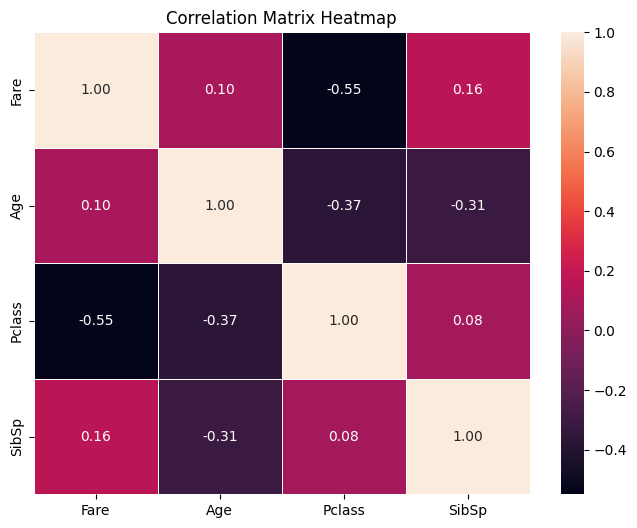

In [5]:
corr_matrix = df.loc[:, ["Fare", "Age", "Pclass", "SibSp"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='rocket', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()


* Most of the passengers were of 3rd class, then 1st class and followed by 2nd class.

Text(0, 0.5, 'Passenger Count')

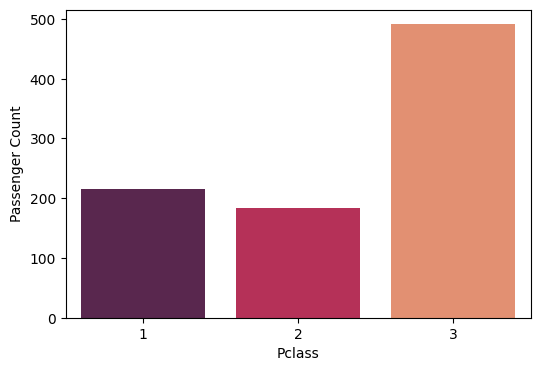

In [6]:
class_frequency = df["Pclass"].value_counts().to_dict()

plt.figure(figsize=(6, 4))
sns.barplot(x=[*class_frequency.keys()], y=[*class_frequency.values()], palette="rocket")
plt.xlabel("Pclass")
plt.ylabel("Passenger Count")


In [7]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
for c in class_frequency.keys():
    class_frequency[c] = {"total": class_frequency[c], "survived": df[(df["Pclass"] == c) & (df["Survived"] == 1)].shape[0]}


In [9]:
class_frequency

{3: {'total': 491, 'survived': 119},
 1: {'total': 216, 'survived': 136},
 2: {'total': 184, 'survived': 87}}

* The trend here is pretty expected 1st class passengers have the highest survival rate, followed by 2nd and 3rd class.

Text(0, 0.5, '% Passenger survived')

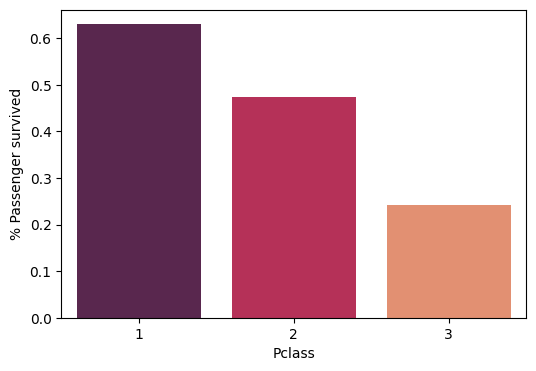

In [10]:
plt.figure(figsize=(6, 4))
sns.barplot(x=[*class_frequency.keys()], y=[v["survived"] / v["total"] for v in class_frequency.values()], palette="rocket")
plt.xlabel("Pclass")
plt.ylabel("% Passenger survived")

In [11]:
gender_frequency = df["Sex"].value_counts().to_dict()
for g in gender_frequency.keys():
    gender_frequency[g] = {"total": gender_frequency[g], "survived": df[(df["Sex"] == g) & (df["Survived"] == 1)].shape[0]}

* Over 70% of the female passengers survived as compared to only 20% of male passengers

Text(0, 0.5, '% Passenger survived')

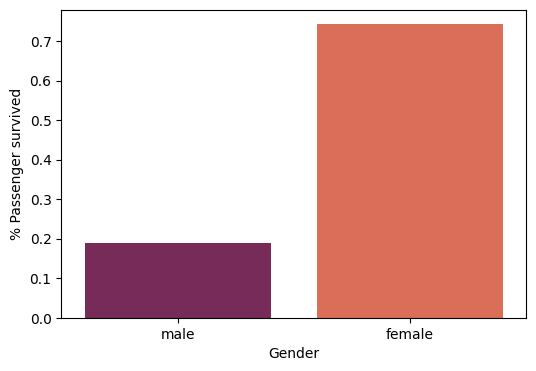

In [12]:

plt.figure(figsize=(6, 4))
sns.barplot(x=[*gender_frequency.keys()], y=[v["survived"] / v["total"] for v in gender_frequency.values()], palette="rocket")
plt.xlabel("Gender")
plt.ylabel("% Passenger survived")

* Most of the passengers had age around 20 - 30 years

Text(0, 0.5, 'Total Passenger')

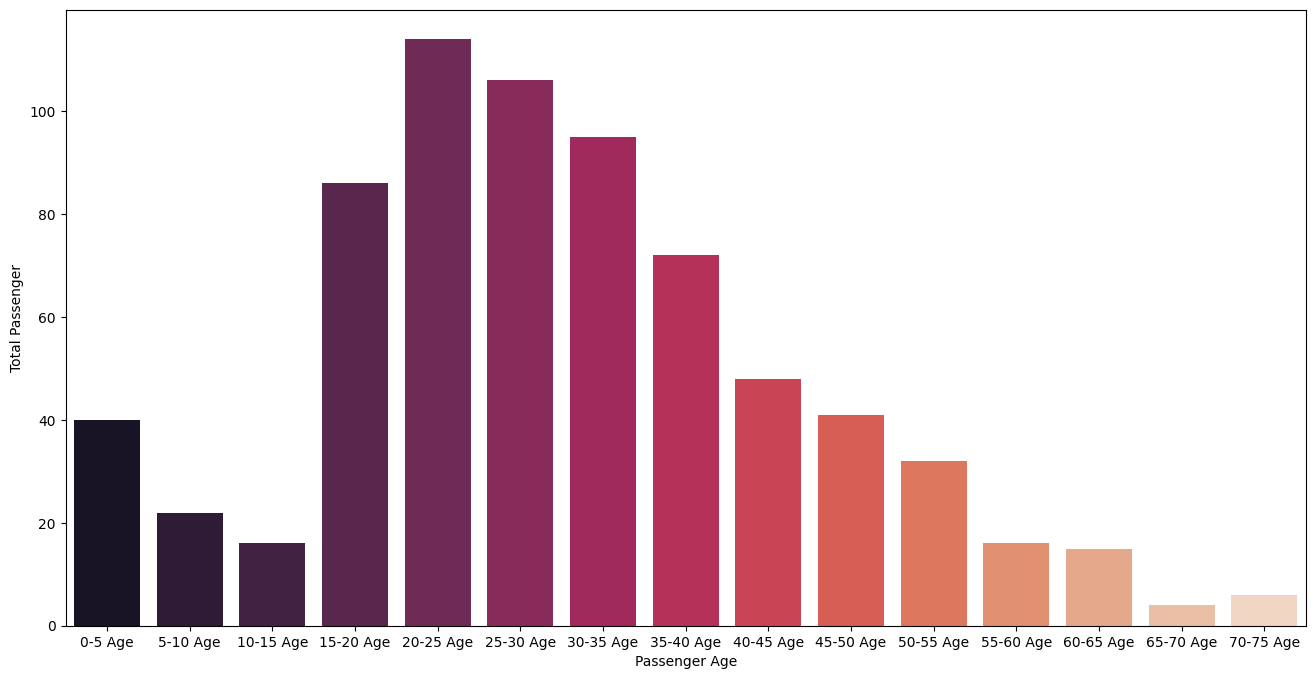

In [13]:
bin_edges = list(range(0, int(df["Age"].max()), 5))  # Example bins from 0 to 80+
bin_labels = [f"{i}-{i+5} Age" for i in bin_edges[:-1]]
df['Age Group'] = pd.cut(df['Age'], bins=bin_edges, labels=bin_labels, right=False)
# plt.scatter(x=df[df["Age"].notna()]["Age"].to_list(),y=df[df["Age"].notna()]["Survived"].to_list())


age_group_frequency = df['Age Group'].value_counts().sort_index().to_dict()

plt.figure(figsize=(16, 8))
sns.barplot(x=[*age_group_frequency.keys()], y=[v for v in age_group_frequency.values()], palette="rocket")
plt.xlabel("Passenger Age")
plt.ylabel("Total Passenger")

In [14]:

age_group_frequency = df["Age Group"].value_counts().sort_index().to_dict()
for g in age_group_frequency.keys():
    age_group_frequency[g] = {"total": age_group_frequency[g], "survived": df[(df["Age Group"] == g) & (df["Survived"] == 1)].shape[0]}

* Higher percent of childrens and elderly people survided as compared to young people

Text(0, 0.5, '% Passenger survived')

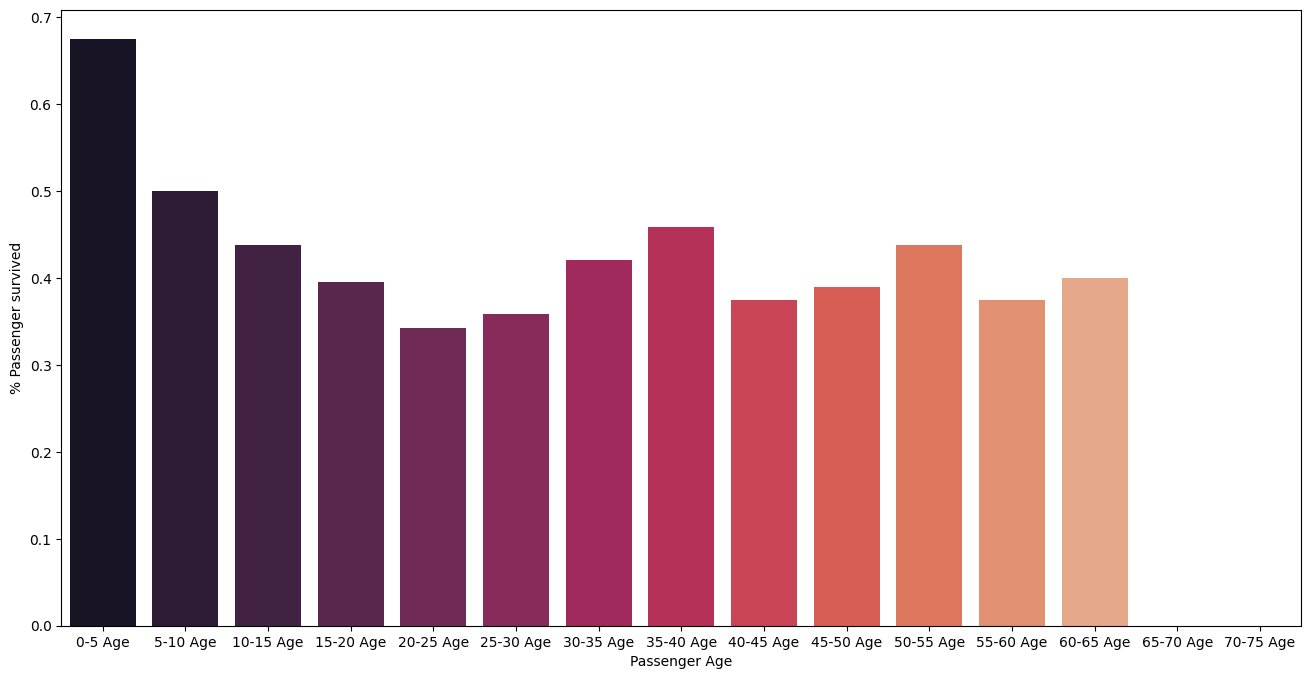

In [15]:

plt.figure(figsize=(16, 8))
sns.barplot(x=[*age_group_frequency.keys()], y=[v["survived"] / v["total"] for v in age_group_frequency.values()], palette="rocket")
plt.xlabel("Passenger Age")
plt.ylabel("% Passenger survived")

## Modelling

We will use LGBM classifier to predict our target and optuna to finetune various hyperparameters of the LGBM classifier

In [16]:
# from lgbm import 
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna

In [17]:
SEED = 42
FOLDS = 5

In [18]:
xdf = df.copy()

In [19]:
xdf.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age Group'],
      dtype='object')

In [20]:
df = xdf.drop(columns=["PassengerId", "Name", "Ticket"]).copy()

In [21]:

df["FoldID"] = 0
X = df.drop(columns=["Survived", "FoldID"])
y = df["Survived"]

In [22]:
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
skf.get_n_splits(X,y)

5

In [23]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    df.loc[test_index, "FoldID"] = i

In [24]:
imputer = SimpleImputer(strategy="median")

In [25]:
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas") 

In [26]:
categorical_columns = ["Age Group", "Sex", "Cabin", "Embarked"]
encoded_categorical_features = encoder.fit_transform(X.loc[:, categorical_columns])
df = pd.concat([df.drop(columns=categorical_columns), encoded_categorical_features], axis=1)

## Feature Engineering

In [27]:
df["Age_And_Fare"] = df["Age"] * df["Fare"]

In [28]:

def get_oof_preds(return_score=True, **params):

    oof_preds = []
    oof_y = []

    for i in range(FOLDS):
        # print(f"FOLD: {i}")
        folddf = df[df["FoldID"] != i]
        X, y = folddf.drop(columns=["Survived", "FoldID"]), folddf["Survived"].values

        feature_names = X.columns
        X = imputer.fit_transform(X)
        
        model = lgb.LGBMClassifier(**params, verbose=-1)
        model.fit(X,y)
    
        folddf =  df[df["FoldID"] == i]
        X_val, y_val = folddf.drop(columns=["Survived", "FoldID"]), folddf["Survived"].values

        X_val = imputer.transform(X_val)
    
        y_pred = model.predict(X_val)
    
        accuracy = accuracy_score(y_val, y_pred)

        oof_preds.extend(y_pred)
        
        oof_y.extend(y_val)
    
    oof_acc = accuracy_score(oof_y, oof_preds)

    if return_score:
        return oof_acc
    else:
        return oof_y, oof_preds, model, feature_names

In [29]:

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }

    accuracy = get_oof_preds(**params)

    return accuracy 


In [38]:


# NOTE: Uncomment to run the optuna trails
# study = optuna.create_study(direction='maximize') 
# study.optimize(objective, n_trials=500)

best_params = {'n_estimators': 262, 'learning_rate': 0.010740547904443606, 'num_leaves': 37, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.7252779991460335, 'colsample_bytree': 0.5478542362157861, 'reg_alpha': 0.017640952819914034, 'reg_lambda': 0.6898654579508066}
print("\nBest Hyperparameters:", best_params)


Best Hyperparameters: {'n_estimators': 262, 'learning_rate': 0.010740547904443606, 'num_leaves': 37, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.7252779991460335, 'colsample_bytree': 0.5478542362157861, 'reg_alpha': 0.017640952819914034, 'reg_lambda': 0.6898654579508066}


In [39]:
oof_y, oof_preds, model, feature_names = get_oof_preds(**best_params, return_score=False)

In [40]:
oof_accuracy_score = accuracy_score(oof_y, oof_preds)
report = classification_report(oof_y, oof_preds)

In [41]:
print(f"OOF Accuracy: {oof_accuracy_score:.4f}")

OOF Accuracy: 0.8530


In [42]:
print(report)

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       549
           1       0.86      0.73      0.79       342

    accuracy                           0.85       891
   macro avg       0.86      0.83      0.84       891
weighted avg       0.85      0.85      0.85       891



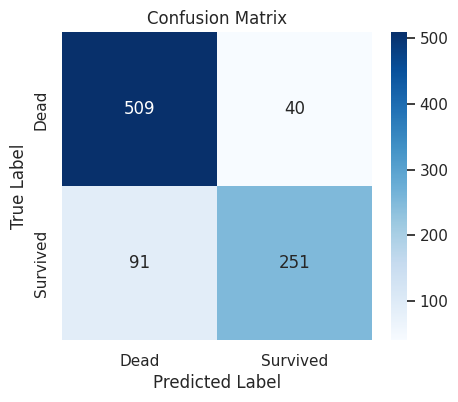

In [43]:

cm = confusion_matrix(oof_y, oof_preds)


plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Dead', 'Survived'], yticklabels=['Dead', 'Survived'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [44]:
feature_names

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age Group_0-5 Age',
       'Age Group_10-15 Age', 'Age Group_15-20 Age', 'Age Group_20-25 Age',
       'Age Group_25-30 Age',
       ...
       'Cabin_F38', 'Cabin_F4', 'Cabin_G6', 'Cabin_T', 'Cabin_nan',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_nan',
       'Age_And_Fare'],
      dtype='object', length=176)

## TOP 16 important features by LGBM classifier

The selected features by the model are very explainable as:

* if you paid higher Fare then it means that you are important/rich man, hence you survive!
* Age if you are a child or elderly then you survive or else if you are young you should float in the middle of Atlantic and test your buoyancy
* if you were staying in a particular class like 1st you are more likely to survive

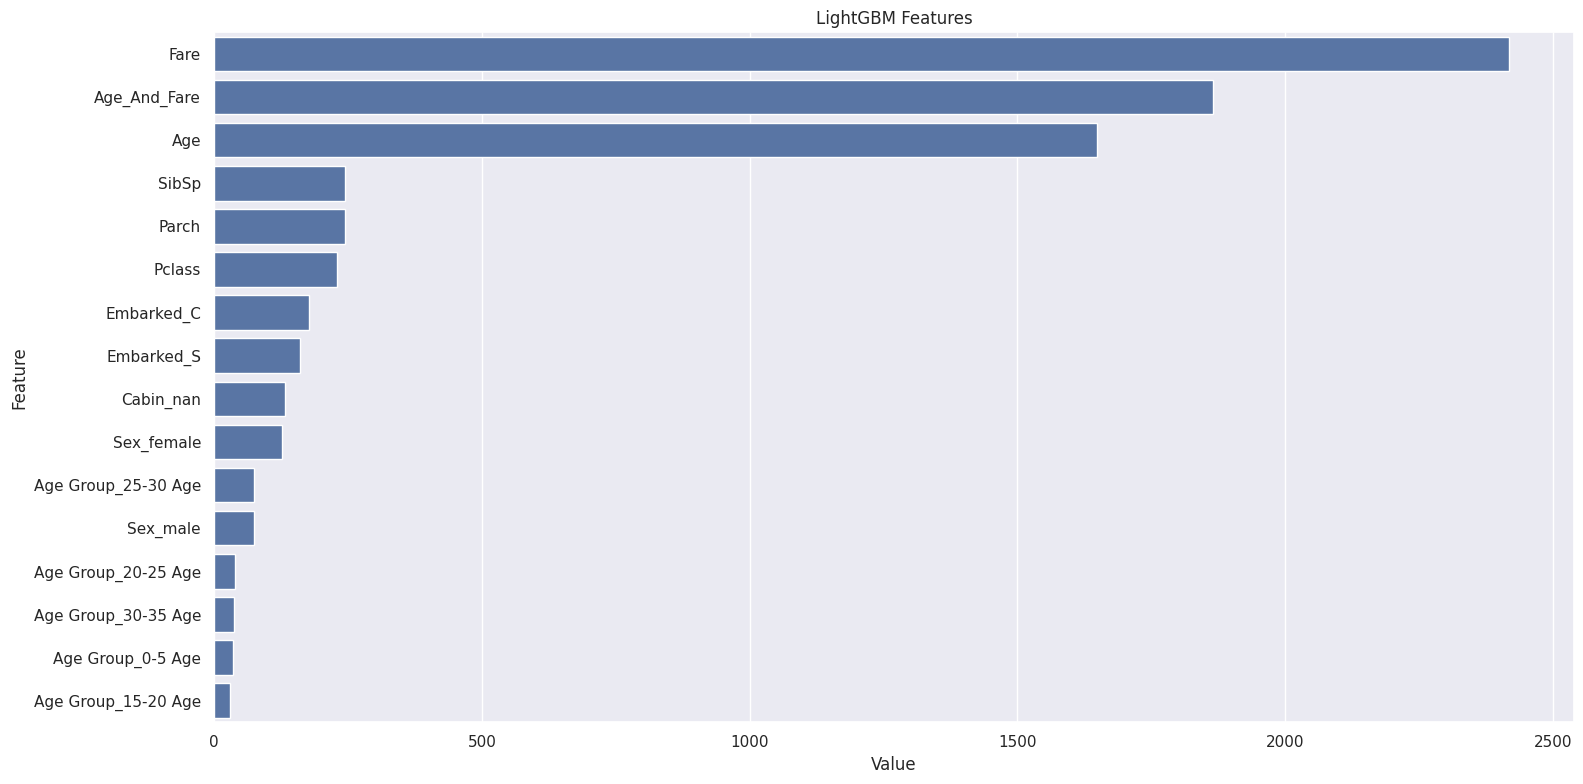

In [45]:
feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':feature_names})
plt.figure(figsize=(16,8))
sns.set(font_scale = 1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False)[0:16])
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()